# Michael Braunstein 
## SI 330 Final Project
## PGA Tour vs Weather

READ ME: You can run all the cells below just please leave the third cell block commented out. I have no more API requests with my key. In the zip file, there is a 'tournament_data.json' file that has all the data that the cell creates. The program will also make two other files within the folder. 


In [1]:
#All my necessary imports
import ast
import csv
import requests
import pandas as pd
import numpy as np
import pprint
import json
from bs4 import BeautifulSoup
import time
from datetime import date, timedelta

Setting up general variables

In [3]:
years = [2017, 2016, 2015,2014]
#tourn_data_dict = {}
form = "json"
api_key = "h2rb3vs4f7mvyqe76ns2qha7"
tournament_names = ["Masters", "Memorial", "PLAYERS","Palmer", "Bridgestone","Waste","Honda","Farmers","Greenbrier","Deere"]

This cell below does not have to be run. Please dont run it as I have no more API requests available so it wont work. Download the file "tournament_data.json" and continue running the file in the cells below. This is the cell where I collect the tournament data for each tournament and save it to a json file. 

In [190]:


# data = []
# for year in years: 
#     tournament_sch_req = requests.get("https://api.sportradar.us/golf-t2/schedule/pga/{}/tournaments/schedule.{}?api_key={}".format(year,form,api_key))
#     time.sleep(1.1)
#     response = tournament_sch_req.text
#     tournament_dict = json.loads(response)
#     for tournament in tournament_names:
#         for tourny in tournament_dict['tournaments']:
#             if tournament in tourny['name']:
#                 print(tournament)
#                 tournament_id = tourny['id']
#                 request = requests.get("https://api.sportradar.us/golf-t2/leaderboard/pga/{}/tournaments/{}/leaderboard.{}?api_key={}".format(year,tournament_id,form,api_key))
#                 response = request.text
#                 data.append(json.loads(response))
#                 time.sleep(1.1)

# # We are writing a json encoded version of the responses from our API requests to tournament_data.json.
# with open('tournament_data.json', 'w') as file:
#     json.dump(data, file)


Masters
Memorial
PLAYERS
Palmer
Bridgestone
Waste
Honda
Farmers
Greenbrier
Deere
Masters
Memorial
PLAYERS
Palmer
Bridgestone
Waste
Honda
Farmers
Greenbrier
Deere
Masters
Memorial
PLAYERS
Palmer
Bridgestone
Waste
Honda
Farmers
Greenbrier
Deere
Masters
Memorial
PLAYERS
Palmer
Bridgestone
Waste
Honda
Farmers
Greenbrier
Deere


Here I loaded the json data, and collected the data I needed from all the metadata I pulled from the API's. I put all this data into a list, and then loaded all that into a csv file.

In [4]:

#Creating the dataframe with the correct data needed from the json file and storing it into a CSV File
raw_data = json.load(open('tournament_data.json'))
expanded_data = []
for tournament in raw_data:
    if 'leaderboard' not in tournament:
        continue
    for lb_entry in tournament['leaderboard']:
        round_count = 1
        for round_info in lb_entry['rounds']:
            new_row = {}
            new_row['start_date'] = tournament['start_date']
            new_row['tournament'] = tournament['name']
            new_row['first_name'] = lb_entry['first_name']
            new_row['last_name'] = lb_entry['last_name']
            new_row['position'] = lb_entry['position']
            new_row['round'] = round_count
            new_row['round_score'] = round_info['score']
            new_row['strokes'] = round_info['strokes']
            new_row['eagles'] = round_info['eagles']
            new_row['birdies'] = round_info['birdies']
            new_row['pars'] = round_info['pars']
            new_row['bogeys'] = round_info['bogeys']
            new_row['double_bogeys'] = round_info['double_bogeys']
            expanded_data.append(new_row)
            round_count+=1
        

df2 = pd.DataFrame(expanded_data)
df2.to_csv('tournament_data.csv')

Run Cell Below after running the import line cell. Download the CSV File and the dataframe will be created from it

In [5]:

#creating a dataframe from the csv file
df_golf = pd.read_csv('tournament_data.csv')
df_golf.head()

,Unnamed: 0,birdies,bogeys,double_bogeys,eagles,first_name,last_name,pars,position,round,round_score,start_date,strokes,tournament
0,0,1,0,0,0,Sergio,Garcia,17,1.0,1,-1,2017-04-06,71,Masters Tournament
1,1,6,3,0,0,Sergio,Garcia,9,1.0,2,-3,2017-04-06,69,Masters Tournament
2,2,4,2,0,0,Sergio,Garcia,12,1.0,3,-2,2017-04-06,70,Masters Tournament
3,3,3,2,0,1,Sergio,Garcia,12,1.0,4,-3,2017-04-06,69,Masters Tournament
4,4,5,4,0,0,Justin,Rose,9,2.0,1,-1,2017-04-06,71,Masters Tournament


I developed a function that would take in a row of the data frame shown above and return the temperpature for that day of that tournament by scraping data from the weather website. I have all 10 links in the "weather_locations" where the date was formatted out so I could figure out each day of the tournament I needed to pull data for. I used a date function to determine the next day of a tournament based on the start date of the tournament and the round number of a given row. I then used BeautifulSoup to srape the website for the mean temperature for the day. 


In [6]:
#Weather Scraping

temps_pulled = {}
def populate_Temp(row):
    weather_locations = {"Masters": "https://www.wunderground.com/history/airport/KDNL/{}/{}/{}/DailyHistory.html?req_city=Augusta&req_state=GA&req_statename=Georgia&reqdb.zip=30901&reqdb.magic=1&reqdb.wmo=99999",
                        "PLAYERS": "https://www.wunderground.com/history/airport/KCRG/{}/{}/{}/DailyHistory.html?req_city=&req_state=&req_statename=&reqdb.zip=&reqdb.magic=&reqdb.wmo=",
                        "Memorial":"https://www.wunderground.com/history/airport/KOSU/{}/{}/{}/DailyHistory.html?req_city=&req_state=&req_statename=&reqdb.zip=&reqdb.magic=&reqdb.wmo=",
                        "Palmer":"https://www.wunderground.com/history/airport/KMCO/{}/{}/{}/DailyHistory.html?req_city=&req_state=&req_statename=&reqdb.zip=&reqdb.magic=&reqdb.wmo=",
                        "Bridgestone": "https://www.wunderground.com/history/airport/KAKR/{}/{}/{}/DailyHistory.html?req_city=&req_state=&req_statename=&reqdb.zip=&reqdb.magic=&reqdb.wmo=",
                        "Waste": "https://www.wunderground.com/history/airport/KSDL/{}/{}/{}/DailyHistory.html?req_city=&req_state=&req_statename=&reqdb.zip=&reqdb.magic=&reqdb.wmo=",
                        "Honda": "https://www.wunderground.com/history/airport/KPBI/{}/{}/{}/DailyHistory.html?req_city=&req_state=&req_statename=&reqdb.zip=&reqdb.magic=&reqdb.wmo=",
                        "Farmers": "https://www.wunderground.com/history/airport/KMYF/{}/{}/{}/DailyHistory.html?req_city=&req_state=&req_statename=&reqdb.zip=&reqdb.magic=&reqdb.wmo=",
                        "Greenbrier": "https://www.wunderground.com/history/airport/KLWB/{}/{}/{}/DailyHistory.html?req_city=&req_state=&req_statename=&reqdb.zip=&reqdb.magic=&reqdb.wmo=",
                        "Deere": "https://www.wunderground.com/history/airport/KMLI/{}/{}/{}/DailyHistory.html?req_city=&req_state=&req_statename=&reqdb.zip=&reqdb.magic=&reqdb.wmo="}
    rd = row["round"]
    tournament = row['tournament']
    days_weather = []
    start = row["start_date"]
    current = start
    if rd == 1: 
        date_strip = current.split("-")
        yr = date_strip[0]
        month = date_strip[1]
        day = date_strip[2]
        for location in weather_locations.keys():
            if location in tournament:
                if current not in temps_pulled.keys():
                    print(location)
                    url = weather_locations[location]        
                    page = requests.get(url.format(yr,month,day))
                    soup = BeautifulSoup(page.content, 'html.parser')
                    temp = soup.find(class_="wx-value")
                    temps_pulled[current] = temp.getText()
                    return temp.getText()
                else: 
                    return temps_pulled[current]
    else:
        t = time.strptime(current,'%Y-%m-%d')
        updated_count = rd-1
        newdate = date(t.tm_year,t.tm_mon,t.tm_mday)+timedelta(updated_count)
        current = newdate.strftime('%Y-%m-%d')
        date_strip = current.split("-")
        yr = date_strip[0]
        month = date_strip[1]
        day = date_strip[2]
        for location in weather_locations.keys():
            if location in tournament: 
                if current not in temps_pulled.keys():
                    url = weather_locations[location]         
                    page = requests.get(url.format(yr,month,day))
                    soup = BeautifulSoup(page.content, 'html.parser')
                    temp = soup.find(class_="wx-value")
                    temps_pulled[current] = temp.getText()
                    return temp.getText()
                else: 
                    return temps_pulled[current]


    



Applying the function I created above to the dataframe to create a new column in the data frame called "temperature" to have the temperature for each given row of the data. 

In [7]:
df_golf["temperature"] = df_golf.apply(populate_Temp, axis = 1)

Masters
Memorial
PLAYERS
Palmer
Bridgestone
Waste
Honda
Farmers
Greenbrier
Deere
Masters
Memorial
PLAYERS
Palmer
Bridgestone
Waste
Honda
Farmers
Deere
Masters
Memorial
PLAYERS
Palmer
Bridgestone
Waste
Honda
Farmers
Greenbrier
Deere
Masters
Memorial
PLAYERS
Palmer
Bridgestone
Waste
Honda
Farmers
Greenbrier
Deere


Normalizing the tournament names


In [7]:
#Normalizing the tournament names
new_tourn_column = []
normalizes_tournament_names = {"The Masters":["The Masters","Masters Tournament"],"Arnold Palmer Invitational":["Arnold Palmer Invitational","Arnold Palmer Invitational presented by MasterCard","Arnold Palmer Invitational presented by Mastercard"],
                               "The PLAYERS Championship":["THE PLAYERS Championship"],"John Deere Classic": ["John Deere Classic"],
                              "Farmers Insurance Open":["Farmers Insurance Open"],"The Honda Classic": ["The Honda Classic"],
                              "Waste Management Open":["Waste Management Phoenix Open"],"The Greenbrier Classic":["The Greenbrier Classic"],
                              "The Memorial Tournament":["the Memorial Tournament","the Memorial Tournament presented by Nationwide"],
                              "Bridgestone Invitational":["World Golf Championships-Bridgestone Invitational","World Golf Championships - Bridgestone Invitational","WGC Bridgestone Invitational"]}
for name in df_golf["tournament"]:
    for tournament in normalizes_tournament_names:
        if name in normalizes_tournament_names[tournament]:
            new_tourn_column.append(tournament)
            df_golf["tournament"] = df_golf["tournament"].replace(name,tournament)

            


Dropping Useless columns


In [8]:
#Droping Useless columns
df_golf = df_golf.drop(columns=['Unnamed: 0'])
df_golf.head()



,birdies,bogeys,double_bogeys,eagles,first_name,last_name,pars,position,round,round_score,start_date,strokes,tournament,temperature
0,1,0,0,0,Sergio,Garcia,17,1.0,1,-1,2017-04-06,71,The Masters,59
1,6,3,0,0,Sergio,Garcia,9,1.0,2,-3,2017-04-06,69,The Masters,57
2,4,2,0,0,Sergio,Garcia,12,1.0,3,-2,2017-04-06,70,The Masters,58
3,3,2,0,1,Sergio,Garcia,12,1.0,4,-3,2017-04-06,69,The Masters,63
4,5,4,0,0,Justin,Rose,9,2.0,1,-1,2017-04-06,71,The Masters,59


Writing final data to a csv file and then reading it in and dropping columns that weren't neeeded

In [9]:
df_golf.to_csv('tournament_weather.csv')

In [10]:
df_golf = pd.read_csv('tournament_weather.csv')
df_golf = df_golf.drop(columns='Unnamed: 0')
df_golf

,birdies,bogeys,double_bogeys,eagles,first_name,last_name,pars,position,round,round_score,start_date,strokes,tournament,temperature
0,1,0,0,0,Sergio,Garcia,17,1.0,1,-1,2017-04-06,71,The Masters,59
1,6,3,0,0,Sergio,Garcia,9,1.0,2,-3,2017-04-06,69,The Masters,57
2,4,2,0,0,Sergio,Garcia,12,1.0,3,-2,2017-04-06,70,The Masters,58
3,3,2,0,1,Sergio,Garcia,12,1.0,4,-3,2017-04-06,69,The Masters,63
4,5,4,0,0,Justin,Rose,9,2.0,1,-1,2017-04-06,71,The Masters,59
5,4,4,0,0,Justin,Rose,10,2.0,2,0,2017-04-06,72,The Masters,57
6,7,2,0,0,Justin,Rose,9,2.0,3,-5,2017-04-06,67,The Masters,58
7,5,2,0,0,Justin,Rose,11,2.0,4,-3,2017-04-06,69,The Masters,63
8,2,4,0,0,Charl,Schwartzel,12,3.0,1,2,2017-04-06,74,The Masters,59
9,5,5,0,0,Charl,Schwartzel,8,3.0,2,0,2017-04-06,72,The Masters,57


In [11]:
best_golfers = df_golf[(df_golf['position'] <=50)].groupby([df_golf.last_name,df_golf.first_name]).size().sort_values(ascending = False)
best_golfers[best_golfers >= 30]
# top_golfers = df_golf[best_golfers[best_golfers >= 30].last_name]



last_name  first_name
Matsuyama  Hideki        92
Johnson    Zach          84
Bradley    Keegan        84
Steele     Brendan       80
Scott      Adam          80
Watson     Bubba         80
Horschel   Billy         76
Haas       Bill          76
Leishman   Marc          72
Fowler     Rickie        72
Holmes     J.B.          68
Na         Kevin         68
Casey      Paul          68
Spieth     Jordan        68
Henley     Russell       68
Mickelson  Phil          64
Hoffman    Charley       64
Chappell   Kevin         64
Day        Jason         64
Reed       Patrick       64
Moore      Ryan          64
Kuchar     Matt          64
Snedeker   Brandt        64
McIlroy    Rory          64
Kisner     Kevin         64
Koepka     Brooks        60
Kirk       Chris         60
Molinari   Francesco     60
Villegas   Camilo        60
Poulter    Ian           60
                         ..
Berger     Daniel        40
Jacobson   Fredrik       40
Johnson    Dustin        40
Stefani    Shawn         4

In [12]:
df_golf.columns

Index(['birdies', 'bogeys', 'double_bogeys', 'eagles', 'first_name',
       'last_name', 'pars', 'position', 'round', 'round_score', 'start_date',
       'strokes', 'tournament', 'temperature'],
      dtype='object')

Creating a new data frame finding the minimum score for each round of each tournament. Resulting data frame has round, round score, temperature, and tournament name and is grouped by the start date and round. 

In [13]:
round_score_df = df_golf.groupby(["start_date","round"])["round_score","temperature","tournament"].min()

In [14]:
round_score_df

round_score  temperature                  tournament
start_date round                                                      
2014-01-23 1               -8           53      Farmers Insurance Open
           2               -9           60      Farmers Insurance Open
           3               -5           63      Farmers Insurance Open
           4               -6           59      Farmers Insurance Open
2014-01-30 1               -7           60       Waste Management Open
           2               -7           58       Waste Management Open
           3               -9           56       Waste Management Open
           4               -6           50       Waste Management Open
2014-02-27 1               -7           71           The Honda Classic
           2               -7           65           The Honda Classic
           3               -5           68           The Honda Classic
           4               -3           69           The Honda Classic
2014-03-20 1              -10           71  Arnold Palmer Invitational
           2               -5           73  Arnold Palmer Invitational
           3               -6           75  Arnold Palmer Invitational
           4               -5           75  Arnold Palmer Invitational
2014-04-10 1               -4           65                 The Masters
           2               -4           66                 The Masters
           3               -6           71                 The Masters
           4               -5           70                 The Masters
2014-05-08 1               -9           78    The PLAYERS Championship
           2               -6           80    The PLAYERS Championship
           3               -5           80    The PLAYERS Championship
           4               -7           80    The PLAYERS Championship
2014-05-29 1               -9           71     The Memorial Tournament
           2               -6           67     The Memorial Tournament
           3               -7           69     The Memorial Tournament
           4               -8           72     The Memorial Tournament
2014-07-03 1               -6           73      The Greenbrier Classic
           2               -9           64      The Greenbrier Classic
...                       ...          ...                         ...
2017-02-23 3               -6           73           The Honda Classic
           4               -6           72           The Honda Classic
2017-03-16 1               -5           52  Arnold Palmer Invitational
           2               -6           58  Arnold Palmer Invitational
           3               -7           64  Arnold Palmer Invitational
           4               -5           68  Arnold Palmer Invitational
2017-04-06 1               -7           59                 The Masters
           2               -5           57                 The Masters
           3               -5           58                 The Masters
           4               -5           63                 The Masters
2017-05-11 1               -5           80    The PLAYERS Championship
           2               -6           80    The PLAYERS Championship
           3               -6           76    The PLAYERS Championship
           4               -4           72    The PLAYERS Championship
2017-06-01 1               -7           64     The Memorial Tournament
           2               -7           68     The Memorial Tournament
           3               -7           70     The Memorial Tournament
           4               -7           75     The Memorial Tournament
2017-07-06 1               -9           71      The Greenbrier Classic
           2               -6           71      The Greenbrier Classic
           3               -5           68      The Greenbrier Classic
           4               -6           65      The Greenbrier Classic
2017-07-13 1               -8           79          John Deere Classic
           2               -8           69

Making the type of round score and temperature to integer/numeric types 

In [15]:
round_score_df[['temperature','round_score']] = round_score_df[['temperature','round_score']].apply(pd.to_numeric)


round_score_df.head()







round_score  temperature              tournament
start_date round                                                  
2014-01-23 1               -8           53  Farmers Insurance Open
           2               -9           60  Farmers Insurance Open
           3               -5           63  Farmers Insurance Open
           4               -6           59  Farmers Insurance Open
2014-01-30 1               -7           60   Waste Management Open

Creating a lmplot plotting the temperature against the round score for the dataframe "round_score_df" and set the hue to the tournament. This will allow the data the be color coded by the tournament of which the data is coming from. 

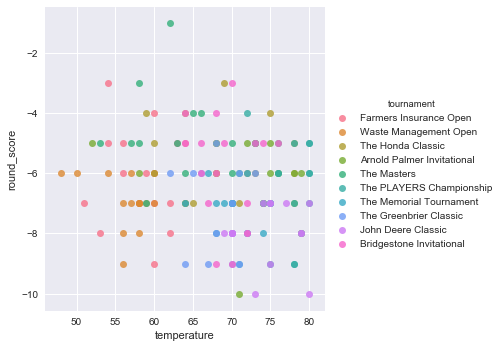

In [16]:
%matplotlib inline
import seaborn as sns
sns.set(style="ticks")
sns.set(color_codes=True)
ax = sns.lmplot(x="temperature",y="round_score", data=round_score_df,fit_reg = False,hue="tournament")

             
             

Creating a regression scatterplot of temperature against round_score and include the regression line. This is based off of the "round_score_df" dataframe. 

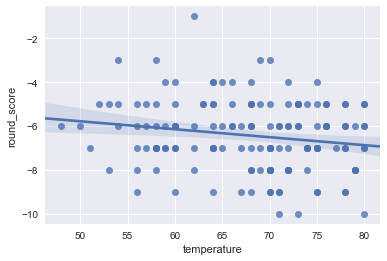

In [17]:
ax = sns.regplot(x="temperature", y="round_score", data=round_score_df)


This is the original plot I created of a regression scatter plot of temperature against round score based on the dataframe "df_golf" which has all 15,000 rows of data, meaning 15,000 data points plotted. 

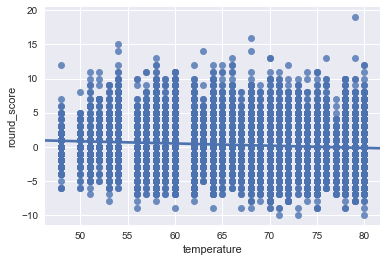

In [18]:
ax = sns.regplot(x="temperature", y="round_score", data=df_golf)
